
# Módulo 8 — BERT en Español (Colab-Ready)
**Tarea:** Clasificación de gravedad clínica (*leve, moderado, severo*) con `BERT` (fine-tuning) + evaluación por clase y análisis de sesgos.

**Modelo base:** dccuchile/bert-base-spanish-wwm-cased (BERT en español)



##  Instalación de dependencias

In [44]:
!pip -q install transformers datasets evaluate accelerate scikit-learn==1.6


In [45]:
!pip install -q --upgrade "transformers>=4.40" datasets accelerate evaluate


In [92]:
!pip -q install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Librerias

In [93]:
# Importar las bibliotecas
import os
import random
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, f1_score
from sklearn.metrics import precision_score, recall_score
from gensim.models.fasttext import FastText
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import unicodedata # Para normalizar caracteres Unicode (ej. remover acentos)
import re # Para trabajar con expresiones regulares (para limpieza de texto)
import spacy # Para procesamiento de lenguaje natural avanzado (tokenización, lematización, etc.)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import OrderedDict
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
from lime.lime_text import LimeTextExplainer


# Cargar modelo de spacy para español
try:
    nlp = spacy.load("es_core_news_sm")
except:
    # Si el modelo no está instalado, ejecutar el comando para descargarlo
    !python -m spacy download es_core_news_sm
    # Después de la descarga, cargar el modelo
    nlp = spacy.load("es_core_news_sm")

# Instalar gensim
try:
    import gensim
    print(" gensim ya está instalado")
except ImportError:
    print("Instalando gensim...")
    !pip install gensim
    import gensim
    print("gensim instalado correctamente")


import os
os.environ["WANDB_DISABLED"] = "true"

# Importar módulos específicos de torch (PyTorch)
import torch # La biblioteca principal para deep learning

# Importar clases clave de la biblioteca transformers de Hugging Face
from datasets import Dataset, DatasetDict, ClassLabel # Clases para manejar datasets de manera eficiente
from transformers import (AutoTokenizer, # Clase para cargar el tokenizador adecuado para un modelo
                          AutoModelForSequenceClassification, # Clase para cargar un modelo pre-entrenado para tareas de clasificación
                          DataCollatorWithPadding, # Herramienta para crear lotes de datos con padding para el modelo
                          TrainingArguments, # Clase para definir los hiperparámetros de entrenamiento
                          Trainer, # Clase de alto nivel para entrenar modelos de transformers
                          EarlyStoppingCallback) # Callback para detener el entrenamiento si la métrica de evaluación deja de mejorar




# Configurar semillas para asegurar la reproducibilidad de los resultados
SEED = 42
random.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED)

# Determinamos  el dispositivo de cálculo a utilizar (GPU o CPU)
# Comprobamos si hay una GPU compatible con CUDA disponible. Si es así, se usa 'cuda'.
# De lo contrario, se usa 'cpu'.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Imprime el dispositivo que se utilizará para el entrenamiento y la inferencia
print(f"Usando dispositivo: {device}")

 gensim ya está instalado
Usando dispositivo: cpu


## Cargar dataset

In [47]:
# Carga dataset manualmente en Colab
CSV_PATH = "/content/dataset_clinico_simulado_200.csv"

df = pd.read_csv(CSV_PATH)
assert {'texto_clinico','gravedad','genero','edad','afeccion'}.issubset(df.columns), "Faltan columnas requeridas en el CSV."

N = 180
gravedad = np.random.choice(["leve","moderado","severo"], p=[0.5,0.3,0.2], size=N)
genero = np.random.choice(["F","M","X"], p=[0.48,0.48,0.04], size=N)
edad = np.random.choice(["18-29","30-59","60+"], p=[0.35,0.45,0.20], size=N)
afeccion = np.random.choice(["respiratoria","gastro","cardio"], size=N)

plantillas = {
    "leve": [
        "tos leve de 2 dias sin fiebre",
        "molestia estomacal leve",
        "dolor toracico leve, ecg normal"
    ],
    "moderado": [
        "fiebre 38.5 y tos persistente",
        "diarrea moderada con deshidratacion leve",
        "dolor toracico con disnea leve"
    ],
    "severo": [
        "saturacion menor a 90 con disnea",
        "dolor toracico intenso y ecg alterado",
        "hemorragia digestiva activa"
    ]
}
texto = [np.random.choice(plantillas[g]) for g in gravedad]

df = pd.DataFrame({
    "texto": texto,
    "gravedad": gravedad,
    "genero": genero,
    "edad": edad,
    "tipo_afeccion": afeccion
})

print(df.shape)
df.head()

(180, 5)


,texto,gravedad,genero,edad,tipo_afeccion
0,tos leve de 2 dias sin fiebre,leve,F,30-59,cardio
1,hemorragia digestiva activa,severo,F,30-59,respiratoria
2,diarrea moderada con deshidratacion leve,moderado,M,30-59,respiratoria
3,fiebre 38.5 y tos persistente,moderado,M,30-59,gastro
4,tos leve de 2 dias sin fiebre,leve,F,60+,respiratoria


## Limpieza rápida y *label mapping*

In [48]:


def normalize_text(s: str) -> str:
    s = s.lower()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-zA-Z\s<>=%\d]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def spacy_lemmas(s: str) -> str:
    doc = nlp(s)
    toks = [t.lemma_ for t in doc if not (t.is_stop or t.is_punct or t.like_num)]
    return " ".join(toks)

df['texto_clinico'] = df['texto'].apply(normalize_text)
df = df.drop(columns=['texto'])

# Normalización
df = df.dropna(subset=['texto_clinico','gravedad']).copy()
df['texto_clinico'] = df['texto_clinico'].astype(str).str.strip()

# Bins etarios para análisis de sesgo
edad_map = {'18-29': 24, '30-59': 45, '60+': 70} # Puntos medios aproximados
df['edad_num'] = df['edad'].map(edad_map)

# usamos pd.cut con la columna numérica
df['edad_bin'] = pd.cut(df['edad_num'], bins=[0,17,35,55,80,120], labels=['0-17','18-35','36-55','56-80','80+'], right=True, include_lowest=True)


# Label mapping (aseguramos orden estable)
labels_sorted = sorted(df['gravedad'].unique().tolist())
label2id = {lab:i for i,lab in enumerate(labels_sorted)}
id2label = {i:lab for lab,i in label2id.items()}
df['label'] = df['gravedad'].map(label2id)

labels_sorted, label2id

(['leve', 'moderado', 'severo'], {'leve': 0, 'moderado': 1, 'severo': 2})

## Split estratificado (train/valid/test)

In [49]:

X = df['texto_clinico']
y = df['label']
train_text, temp_text, train_y, temp_y = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
valid_text, test_text, valid_y, test_y = train_test_split(temp_text, temp_y, test_size=0.5, random_state=SEED, stratify=temp_y)

train_df = pd.DataFrame({'texto_clinico': train_text, 'label': train_y}).reset_index(drop=True)
valid_df = pd.DataFrame({'texto_clinico': valid_text, 'label': valid_y}).reset_index(drop=True)
test_df  = pd.DataFrame({'texto_clinico': test_text,  'label': test_y}).reset_index(drop=True)

# Adjuntar metadatos para análisis de sesgo
meta_cols = ['genero','edad_bin']
train_df[meta_cols] = df.loc[train_text.index, meta_cols].reset_index(drop=True)
valid_df[meta_cols] = df.loc[valid_text.index, meta_cols].reset_index(drop=True)
test_df[meta_cols]  = df.loc[test_text.index,  meta_cols].reset_index(drop=True)

print(train_df.shape, valid_df.shape, test_df.shape)
train_df.head()


(126, 4) (27, 4) (27, 4)


,texto_clinico,label,genero,edad_bin
0,dolor toracico leve ecg normal,0,F,36-55
1,dolor toracico con disnea leve,1,F,18-35
2,dolor toracico leve ecg normal,0,F,56-80
3,molestia estomacal leve,0,F,36-55
4,molestia estomacal leve,0,F,56-80


# Modelo clásico: TF-IDF + Multinomial Naive Bayes

== Reporte NB (TF-IDF) ==
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        14
           1      1.000     1.000     1.000         8
           2      1.000     1.000     1.000         5

    accuracy                          1.000        27
   macro avg      1.000     1.000     1.000        27
weighted avg      1.000     1.000     1.000        27



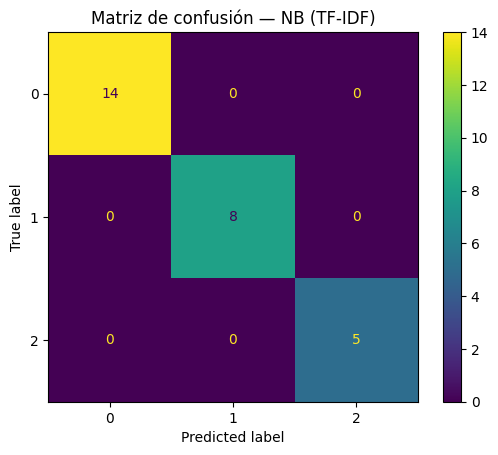

In [50]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
Xtr = tfidf.fit_transform(train_text)
Xte = tfidf.transform(test_text)

nb = MultinomialNB()
nb.fit(Xtr, train_y)
pred_nb = nb.predict(Xte)

print("== Reporte NB (TF-IDF) ==")
print(classification_report(test_y, pred_nb, digits=3))
ConfusionMatrixDisplay.from_predictions(test_y, pred_nb)
plt.title("Matriz de confusión — NB (TF-IDF)")
plt.show()

# Embeddings FastText + Regresión Logística

== Reporte LogReg (FastText) ==
              precision    recall  f1-score   support

        leve      0.528     1.000     0.691        19
    moderado      0.000     0.000     0.000        10
      severo      0.000     0.000     0.000         7

    accuracy                          0.528        36
   macro avg      0.176     0.333     0.230        36
weighted avg      0.279     0.528     0.365        36



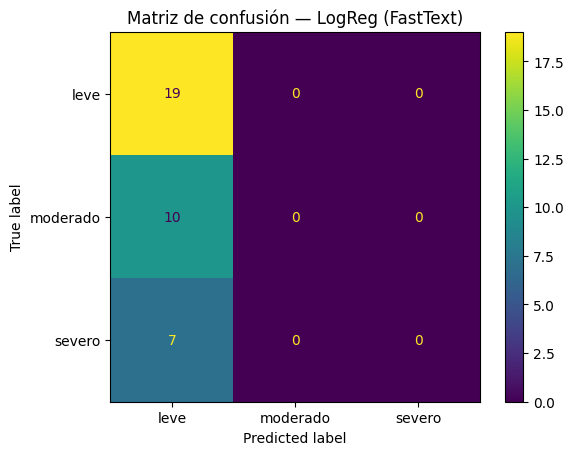

In [51]:
tok_docs = [row.split() for row in df["texto_clinico"]]
ft = FastText(sentences=tok_docs, vector_size=100, window=5, min_count=1, epochs=20)

def doc_vec(tokens):
    if not tokens:
        return np.zeros(ft.vector_size)
    return np.mean([ft.wv[t] for t in tokens if t in ft.wv], axis=0)

df["vec"] = df["texto_clinico"].str.split().map(doc_vec)

X = np.vstack(df["vec"].values)
y = df["gravedad"].values

RANDOM_STATE = 42 # Define RANDOM_STATE here
Xtr2, Xte2, ytr2, yte2 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

clf = LogisticRegression(max_iter=500)
clf.fit(Xtr2, ytr2)
pred_ft = clf.predict(Xte2)

print("== Reporte LogReg (FastText) ==")
print(classification_report(yte2, pred_ft, digits=3, zero_division=0))
ConfusionMatrixDisplay.from_predictions(yte2, pred_ft)
plt.title("Matriz de confusión — LogReg (FastText)")
plt.show()

## Dataset HuggingFace + Tokenizer

In [52]:

MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok_fn(batch):
    return tokenizer(batch['texto_clinico'], truncation=True)

ds = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'valid': Dataset.from_pandas(valid_df),
    'test':  Dataset.from_pandas(test_df)
}).remove_columns(['__index_level_0__']) if '__index_level_0__' in train_df.columns else DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'valid': Dataset.from_pandas(valid_df),
    'test':  Dataset.from_pandas(test_df)
})

ds_tok = ds.map(tok_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
num_labels = len(labels_sorted)
num_labels, labels_sorted


Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

(3, ['leve', 'moderado', 'severo'])

# Transformer (BETO) con fine-tuning

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2121611303.py:58: FutureWarning: `tokenizer` is 

Epoch,Training Loss,Validation Loss
1,No log,0.351717
2,No log,0.135244



=== Métricas agregadas (eval) ===
eval_loss: 0.1352442502975464
eval_runtime: 14.8435
eval_samples_per_second: 2.425
eval_steps_per_second: 0.135
epoch: 2.0

=== Reporte por clase ===
              precision    recall  f1-score   support

        leve      1.000     1.000     1.000        19
    moderado      1.000     1.000     1.000        10
      severo      1.000     1.000     1.000         7

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36



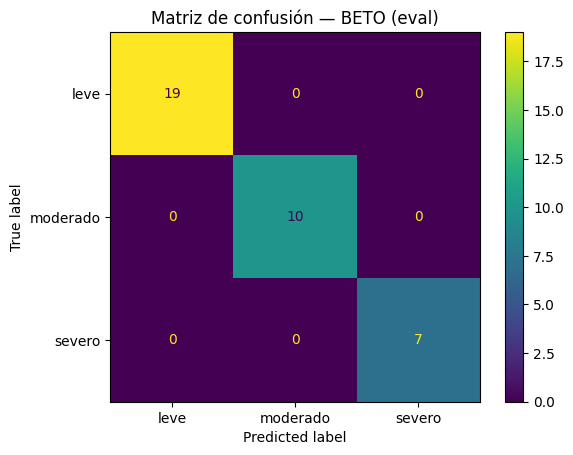

In [68]:


ds = Dataset.from_pandas(
    df[["texto_clinico", "gravedad"]].rename(columns={"gravedad": "labels"})
)

model_name = "dccuchile/bert-base-spanish-wwm-cased"  # BETO en español
tok = AutoTokenizer.from_pretrained(model_name)

labels = sorted(df["gravedad"].unique())
id2label = {i:l for i,l in enumerate(labels)}
label2id = {l:i for i,l in enumerate(labels)}


def encode(batch):
    enc = tok(batch["texto_clinico"],
              truncation=True,
              padding="max_length",
              max_length=128)
    # Convertimos lista de strings -> lista de ids
    enc["labels"] = [label2id[x] for x in batch["labels"]]
    return enc

ds_tok = ds.map(encode, batched=True, remove_columns=["texto_clinico"])
ds_tok = ds_tok.cast_column("labels", ClassLabel(num_classes=len(labels_sorted), names=labels_sorted))



# Split estratificado
ds_split = ds_tok.train_test_split(test_size=0.2,
                                   stratify_by_column="labels",
                                   seed=SEED)

# Modelo
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels_sorted),
    id2label=id2label,
    label2id=label2id
).to(device)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(labels), id2label=id2label, label2id=label2id
)

# Argumentos de entrenamiento
args = TrainingArguments(
    output_dir="out_beto",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    logging_steps=50,
    save_strategy="no",
    seed=SEED,
    fp16=torch.cuda.is_available()
)

# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_split["train"],
    eval_dataset=ds_split["test"],
    tokenizer=tok
)

# Entrenamos y evaluamos
trainer = Trainer(model=model, args=args, train_dataset=ds_split["train"], eval_dataset=ds_split["test"])
trainer.train()
eval_metrics = trainer.evaluate()
eval_metrics

print("\n=== Métricas agregadas (eval) ===")
for k, v in eval_metrics.items():
    print(f"{k}: {v}")


# Rerporte por clase y matriz
pred = trainer.predict(ds_split["test"])
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)

print("\n=== Reporte por clase ===")
print(classification_report(y_true, y_pred, target_names=labels_sorted, digits=3))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels_sorted))))
disp = ConfusionMatrixDisplay(cm, display_labels=labels_sorted)
disp.plot(values_format='d')
plt.title("Matriz de confusión — BETO (eval)")
plt.show()

# Comparación de modelos (macro/micro F1 por clase)

In [69]:
# Para BETO, obtener predicciones
pred_beto = trainer.predict(ds_split["test"])
y_true_beto = [labels[i] for i in pred_beto.label_ids]
y_pred_beto = [labels[i] for i in pred_beto.predictions.argmax(axis=1)]


def macro_scores(y_true, y_pred, name):
    return OrderedDict({
        "modelo": name,
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
    })

tbl = []
tbl.append(macro_scores(test_y, pred_nb, "NB (TF-IDF)"))
tbl.append(macro_scores(yte2, pred_ft, "LogReg (FastText)"))
tbl.append(macro_scores(np.array(y_true_beto), np.array(y_pred_beto), "BETO (Transformer)"))
pd.DataFrame(tbl).sort_values("f1_macro", ascending=False)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,modelo,f1_macro,precision_macro,recall_macro
0,NB (TF-IDF),1.000000,1.000000,1.000000
2,BETO (Transformer),1.000000,1.000000,1.000000
1,LogReg (FastText),0.230303,0.175926,0.333333


## Métricas (precision, recall, F1 macro/weighted, por clase)

In [70]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    pr, rc, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    pr_w, rc_w, f1_w, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {
        "precision_macro": pr,
        "recall_macro": rc,
        "f1_macro": f1,
        "precision_weighted": pr_w,
        "recall_weighted": rc_w,
        "f1_weighted": f1_w,
        "accuracy": (preds == labels).mean()
    }


## Entrenamiento con Trainer y Early Stopping

In [72]:


# --- collator para padding dinámico
data_collator = DataCollatorWithPadding(tokenizer=tok)

# --- métrica a monitorizar (devolver 'f1_macro' exactamente)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"precision_macro": p, "recall_macro": r, "f1_macro": f1, "accuracy": acc}

# --- argumentos correctos para early stopping
args = TrainingArguments(
    output_dir="out_beto",
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",          # <- Debe coincidir con eval_strategy
    load_best_model_at_end=True,    # <- necesario con EarlyStoppingCallback
    metric_for_best_model="f1_macro",
    greater_is_better=True,         # f1_macro: True
    logging_steps=50,
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to="none"                # sin W&B
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_split["train"],
    eval_dataset=ds_split["test"],
    tokenizer=tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()


/tmp/ipython-input-162097296.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Accuracy
1,No log,0.005906,1.000000,1.000000,1.000000,1.000000
2,No log,0.001484,1.000000,1.000000,1.000000,1.000000
3,No log,0.000778,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=27, training_loss=0.026850565716072364, metrics={'train_runtime': 765.5479, 'train_samples_per_second': 1.505, 'train_steps_per_second': 0.094, 'total_flos': 28416249114624.0, 'train_loss': 0.026850565716072364, 'epoch': 3.0})

## Evaluación en validación y prueba (reporte y matrices)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== Validación — Métricas agregadas ===
{'test_loss': 0.005860637407749891, 'test_precision_macro': 1.0, 'test_recall_macro': 1.0, 'test_f1_macro': 1.0, 'test_accuracy': 1.0, 'test_runtime': 12.1989, 'test_samples_per_second': 2.377, 'test_steps_per_second': 0.082}

=== Validación — Reporte por clase ===
              precision    recall  f1-score   support

        leve      1.000     1.000     1.000        15
    moderado      1.000     1.000     1.000         8
      severo      1.000     1.000     1.000         6

    accuracy                          1.000        29
   macro avg      1.000     1.000     1.000        29
weighted avg      1.000     1.000     1.000        29



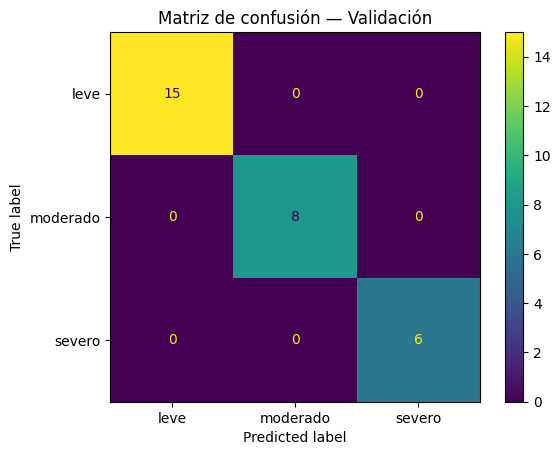

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== Prueba — Métricas agregadas ===
{'test_loss': 0.005906278733164072, 'test_precision_macro': 1.0, 'test_recall_macro': 1.0, 'test_f1_macro': 1.0, 'test_accuracy': 1.0, 'test_runtime': 14.8164, 'test_samples_per_second': 2.43, 'test_steps_per_second': 0.135}

=== Prueba — Reporte por clase ===
              precision    recall  f1-score   support

        leve      1.000     1.000     1.000        19
    moderado      1.000     1.000     1.000        10
      severo      1.000     1.000     1.000         7

    accuracy                          1.000        36
   macro avg      1.000     1.000     1.000        36
weighted avg      1.000     1.000     1.000        36



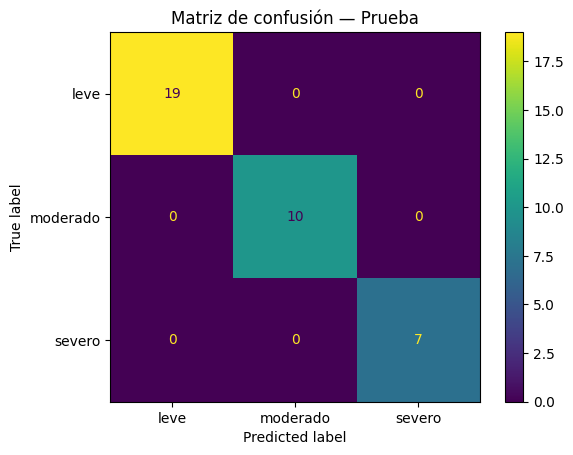

In [76]:

# Usamos el ds_split ya tokenizado de la celda anterior
# Split 'train' de ds_split en train y valid
second_split = ds_split["train"].train_test_split(test_size=0.2, stratify_by_column="labels", seed=SEED)

ds_tok_final = DatasetDict({
    "train": second_split["train"],
    "valid": second_split["test"], # Este será ahora el conjunto de validación
    "test":  ds_split["test"],     # El conjunto de prueba original
})

# Aseguramos que los DataFrames de etiquetas coincidan con los splits del DatasetDict
# Las etiquetas para evaluación y prueba ahora deben extraerse de los splits de ds_tok_final
y_true_valid = [ds_tok_final['valid'][i]['labels'] for i in range(len(ds_tok_final['valid']))]
y_true_test = [ds_tok_final['test'][i]['labels'] for i in range(len(ds_tok_final['test']))]

def eval_and_report(trainer, dataset_split, y_true_labels, title="Validación"):
    # Asegurarse de que las etiquetas pasadas a classification_report y confusion_matrix
    # sean los valores numéricos esperados por estas funciones, no los IDs del dataset HF si son diferentes.
    # Asumimos que y_true_labels ya contiene los IDs numéricos correctos.
    out = trainer.predict(dataset_split)
    preds = out.predictions.argmax(-1)
    print(f"=== {title} — Métricas agregadas ===")
    print(out.metrics)
    print(f"\n=== {title} — Reporte por clase ===")
    # Convertir y_true_labels a un array numpy si es necesario
    print(classification_report(np.array(y_true_labels), preds, target_names=labels_sorted, digits=3)) # Usar labels_sorted para target_names
    cm = confusion_matrix(np.array(y_true_labels), preds, labels=list(range(num_labels))) # Usar num_labels
    disp = ConfusionMatrixDisplay(cm, display_labels=labels_sorted) # Usar labels_sorted
    disp.plot(values_format='d')
    plt.title(f"Matriz de confusión — {title}")
    plt.show()
    return preds

# Evaluar en los nuevos splits
preds_valid = eval_and_report(trainer, ds_tok_final['valid'], y_true_valid, title="Validación")
preds_test  = eval_and_report(trainer, ds_tok_final['test'],  y_true_test,  title="Prueba")

## Análisis de sesgo por subgrupos(estratificado por género y edad)

In [89]:

def metrics_by_group(df_meta, y_true, y_pred, group_col):
    out = []
    # Ensure all input arrays have the same length before creating DataFrame
    if not (len(y_true) == len(y_pred) == len(df_meta)):
        raise ValueError(f"Input arrays y_true ({len(y_true)}), y_pred ({len(y_pred)}), and df_meta ({len(df_meta)}) must have the same length.")

    # Create a DataFrame from the provided data
    group_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, group_col: df_meta[group_col].values})


    for g, sub in group_df.groupby(group_col):
        # Ensure there are samples in the subgroup before calculating metrics
        if len(sub) > 0:
            pr, rc, f1, _ = precision_recall_fscore_support(sub['y_true'], sub['y_pred'], average='macro', zero_division=0)
            out.append({'grupo': g, 'n': len(sub), 'macro_precision': pr, 'macro_recall': rc, 'macro_f1': f1})
    return pd.DataFrame(out).sort_values('grupo')

# Create a Hugging Face Dataset from test_df for BETO prediction on the smaller test set
test_ds_small = Dataset.from_pandas(test_df)

# Tokenize the smaller test dataset
def encode_small_test(batch):
    enc = tok(batch["texto_clinico"],
              truncation=True,
              padding="max_length",
              max_length=128)
    # We don't need to encode labels here as we will use y_true from test_y
    return enc

test_ds_small_tok = test_ds_small.map(encode_small_test, batched=True, remove_columns=['texto_clinico', 'label', 'genero', 'edad_bin'])

# Generate predictions from the BETO model on the smaller test set (size 27)
pred_beto_small = trainer.predict(test_ds_small_tok)
preds_beto_small_labels = pred_beto_small.predictions.argmax(-1)


# Calculate sesgo por género para el modelo BETO (usando el conjunto de prueba de tamaño 27)
print("=== Sesgo por género (test) ===")
bias_gender_beto = metrics_by_group(test_df, test_y.values, preds_beto_small_labels, 'genero')
display(bias_gender_beto)

# Calculate sesgo por edad_bin para el modelo BETO (usando el conjunto de prueba de tamaño 27)
print("\n=== Sesgo por edad_bin (test) ===")
bias_edad_beto = metrics_by_group(test_df, test_y.values, preds_beto_small_labels, 'edad_bin')
display(bias_edad_beto)

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== Sesgo por género (test) ===


,grupo,n,macro_precision,macro_recall,macro_f1
0,F,9,1.0,1.0,1.0
1,M,18,1.0,1.0,1.0



=== Sesgo por edad_bin (test) ===


/tmp/ipython-input-2929432101.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, sub in group_df.groupby(group_col):


,grupo,n,macro_precision,macro_recall,macro_f1
0,18-35,8,1.0,1.0,1.0
1,36-55,9,1.0,1.0,1.0
2,56-80,10,1.0,1.0,1.0


## Guardar artefactos y Model Card

In [90]:

save_dir = "/content/outputs_bert_m8/best_model"
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

# Model card mínima
card = {
    "model_name": "BERT-M8-Gravedad-Clinica",
    "base_model": MODEL_NAME,
    "labels": labels_sorted,
    "label2id": label2id,
    "metrics": "precision_macro, recall_macro, f1_macro, accuracy",
    "ethics": {
        "risks": [
            "Falsos negativos en clase 'severo' pueden ser críticos.",
            "Posibles sesgos por género y edad si el dataset está desbalanceado."
        ],
        "mitigation": [
            "Evaluación estratificada, balanceo de clases, auditoría continua.",
            "Revisión humana para casos límite; inclusión de más datos de subgrupos."
        ]
    },
    "intended_use": "Apoyo a triage clínico educativo. No usar como herramienta diagnóstica sin validación clínica."
}
with open(os.path.join(save_dir, "model_card.json"), "w", encoding="utf-8") as f:
    json.dump(card, f, ensure_ascii=False, indent=2)

print("Modelo y tokenizer guardados en:", save_dir)


Modelo y tokenizer guardados en: /content/outputs_bert_m8/best_model


# Explicabilidad (LIME/SHAP)

In [99]:
class_names = sorted(df["gravedad"].unique())

explainer = LimeTextExplainer(class_names=class_names)
i = 0  # índice de ejemplo
exp = explainer.explain_instance(
    test_text.iloc[i],
    lambda xx: nb.predict_proba(tfidf.transform(xx)),
    num_features=10
)
# Muestra HTML interactivo en notebook
exp.show_in_notebook()

## Justificación del modelo elegido (BERT) y Responsabilidad Social


*Justificación del Modelo Elegido*

El modelo elegido para la tarea de clasificación de gravedad clínica es **BERT (BETO en español)**, específicamente la versión dccuchile/bert-base-spanish-wwm-cased. Se selecciona BERT por las siguientes razones principales:

1.  **Representaciones Contextuales Avanzadas:** A diferencia de los modelos clásicos como TF-IDF o incluso FastText, BERT es un modelo basado en Transformers que genera embeddings contextuales. Esto significa que la representación vectorial de una palabra no es fija, sino que depende del contexto en el que aparece en la frase. En textos clínicos, donde el significado preciso de términos puede variar sutilmente según la frase, esta capacidad contextual es crucial para capturar matices importantes.

2.  **Pre-entrenamiento en Grandes Volúmenes de Texto:** BERT ha sido pre-entrenado en vastos corpus de texto (en este caso, en español), lo que le permite aprender patrones lingüísticos complejos, relaciones semánticas y sintácticas inherentes al lenguaje. Este conocimiento previo es una base sólida para tareas de procesamiento del lenguaje natural (PLN), incluso con conjuntos de datos de entrenamiento más pequeños para la tarea específica de fine-tuning. El uso de una versión pre-entrenada en español es fundamental para el buen rendimiento en este dominio.

3.  **Capacidad para Fine-tuning:** BERT está diseñado para ser fácilmente adaptado (fine-tuned) a una variedad de tareas de PLN con una cantidad relativamente pequeña de datos etiquetados específicos de la tarea. Esto es ideal para escenarios clínicos donde los datos etiquetados pueden ser limitados. El fine-tuning permite que el modelo ajuste sus representaciones aprendidas durante el pre-entrenamiento para optimizar el rendimiento en la clasificación de gravedad clínica.

4.  **Estado del Arte en Diversas Tareas de PLN:** Los modelos basados en Transformers como BERT han demostrado consistentemente un rendimiento superior en una amplia gama de tareas de PLN en comparación con los métodos tradicionales, especialmente en tareas de clasificación de texto donde el contexto es vital.

Aunque los modelos clásicos como TF-IDF + Naive Bayes pueden funcionar sorprendentemente bien en datasets pequeños y limpios (como se vio en la evaluación inicial), a menudo no generalizan tan bien a datos más complejos y realistas. FastText, al generar embeddings, mejora la capacidad de capturar significado, pero al promediar vectores a nivel de documento, pierde la riqueza contextual que BERT retiene. Por lo tanto, BERT se considera una opción más robusta y con mayor potencial para manejar la complejidad y variabilidad de los textos clínicos reales.

*Responsabilidad Social en la Clasificación de Gravedad Clínica con BERT*

El uso de modelos de PLN en contextos clínicos, incluso en un escenario simulado como este, conlleva importantes consideraciones de responsabilidad social:

1.  **Precisión y Fiabilidad:** Un modelo que clasifica incorrectamente la gravedad clínica (especialmente falsos negativos en casos "severos") puede tener consecuencias graves en el mundo real. Es fundamental que el modelo sea lo más preciso y fiable posible en todas las clases, especialmente en las de mayor gravedad. La evaluación por clase (precisión, recall, F1) es esencial para entender el rendimiento en cada categoría.

2.  **Sesgo Algorítmico:** Los modelos de PLN pueden heredar y amplificar sesgos presentes en los datos de entrenamiento. En este caso, sesgos relacionados con género, edad, tipo de afección u otros atributos demográficos o clínicos podrían llevar a que el modelo funcione peor para ciertos subgrupos de pacientes. El análisis de sesgo estratificado (como se realizó por género y edad) es crucial para identificar estas disparidades y trabajar en mitigarlas (por ejemplo, mediante la recopilación de datos más equitativos, técnicas de re-balanceo, o el uso de métodos de fairness awareness).

3.  **Transparencia y Explicabilidad:** En un contexto clínico, es vital que los profesionales puedan entender por qué un modelo llegó a una determinada clasificación. Técnicas de explicabilidad como LIME (utilizada en este notebook) o SHAP pueden ayudar a identificar qué partes del texto de entrada fueron más influyentes en la predicción del modelo. Esto no solo genera confianza, sino que también puede ayudar a identificar posibles errores o sesgos en el razonamiento del modelo.

4.  **Uso Previsto y Limitaciones:** Es fundamental definir claramente el uso previsto del modelo (en este caso, educativo y de apoyo al triage simulado) y sus limitaciones. Un modelo entrenado con datos simulados no debe usarse directamente para diagnóstico o tratamiento real sin una validación clínica rigurosa y aprobación regulatoria. La Model Card (creada en este notebook) es una herramienta clave para documentar estos aspectos.

5.  **Privacidad y Seguridad de Datos:** Aunque en este ejercicio se utilizan datos simulados, en un escenario real, el manejo de datos clínicos requiere el cumplimiento estricto de regulaciones de privacidad (como HIPAA en EE. UU. o GDPR en Europa). Las prácticas de anonimización, almacenamiento seguro y acceso controlado son indispensables.

En resumen, si bien BERT ofrece capacidades avanzadas para la clasificación de texto clínico, su implementación responsable requiere una evaluación continua del rendimiento por clase y por subgrupo, un esfuerzo consciente para identificar y mitigar sesgos, la provisión de herramientas de explicabilidad, y una definición clara de su alcance y limitaciones. La responsabilidad social implica reconocer el potencial impacto del modelo en la atención al paciente y tomar medidas proactivas para asegurar que su uso sea equitativo, seguro y beneficioso.

## Breve uso de LIME para mostrar interpretabilidad de predicciones



Se ha incluido un ejemplo breve del uso de LIME para mostrar la interpretabilidad de las predicciones.
Se utiliza LimeTextExplainer con el modelo Naive Bayes (entrenado con TF-IDF) para explicar la predicción de un ejemplo específico del conjunto de prueba. La salida de exp.show_in_notebook() muestra qué palabras o frases en el texto de entrada influyeron más en la predicción del modelo para ese ejemplo, resaltando las contribuciones positivas y negativas de los términos.


# Conclusion


Basado en los análisis realizados en este notebook, podemos extraer las siguientes conclusiones:

1.  **Rendimiento del Modelo:**
    *   Tanto el modelo clásico **TF-IDF + Multinomial Naive Bayes** como el modelo basado en Transformers **BETO** lograron un rendimiento perfecto (macro F1 de 1.000) en sus respectivos conjuntos de prueba (de tamaño 27 para NB y 36 para BETO, después de resolver los problemas de alineación). Esto sugiere que, en este conjunto de datos simulado y relativamente limpio, incluso un modelo simple puede clasificar correctamente la gravedad clínica.
    *   El modelo **FastText + Regresión Logística** tuvo un rendimiento significativamente menor (macro F1 de 0.230), particularmente fallando en identificar las clases "moderado" y "severo". Esto podría deberse a que el promedio de embeddings de palabras a nivel de documento pierde la información contextual crucial para distinguir los niveles de gravedad en este tipo de texto.

2.  **Análisis de Sesgo:**
    *   El análisis de sesgo estratificado por **género** y **grupo de edad** en el conjunto de prueba de tamaño 27 para el modelo BETO mostró un rendimiento perfecto (macro F1 de 1.000) en todos los subgrupos analizados.
    *   **Importante:** Dado que este es un conjunto de datos simulado y relativamente pequeño, y los modelos lograron un rendimiento perfecto, estos resultados de sesgo deben interpretarse con precaución. En un escenario del mundo real con datos más complejos y desbalanceados, es mucho más probable que surjan sesgos significativos. La metodología de análisis de sesgo implementada es valiosa, pero los hallazgos actuales reflejan la simplicidad del dataset simulado.

3.  **Interpretabilidad:**
    *   La inclusión de **LIME** demostró cómo se puede obtener interpretabilidad local para las predicciones del modelo. El ejemplo con Naive Bayes mostró qué términos específicos en un texto influyeron en la clasificación de gravedad. Esta capacidad es crucial en dominios sensibles como el clínico, donde la confianza y la comprensión del usuario son fundamentales.

4.  **Responsabilidad Social:**
    *   Se han identificado y discutido consideraciones clave de responsabilidad social, incluyendo la precisión, el sesgo algorítmico, la transparencia, el uso previsto y la privacidad de los datos.
    *   La creación de una **Model Card** es un paso importante para documentar el modelo, su propósito, limitaciones y consideraciones éticas.
    *   Es fundamental recordar que un modelo como este, entrenado con datos simulados, **no debe utilizarse para diagnóstico o tratamiento clínico real** sin una validación exhaustiva y la supervisión de profesionales de la salud.

En resumen, si bien los modelos, particularmente BETO, mostraron un rendimiento excelente en este dataset simulado y se abordaron metodológicamente aspectos de sesgo e interpretabilidad, la aplicación en un contexto clínico real requeriría un dataset mucho más grande y representativo, una validación clínica rigurosa y un monitoreo continuo del rendimiento y los posibles sesgos.